# Lexical network analysis (2)

## Loading

In [1]:
### Initialisation of the absolute Github repository path :

from pathlib import Path
import sys

try:
    root = Path(__file__).resolve().parent
except NameError:
    root = Path.cwd()

while root.parent != root:
    if any((root / marker).exists() for marker in [".git", "README.md", "results.ipynb", "README.txt"]):
        break
    root = root.parent

# Fallback in case nothing found
if not any((root / marker).exists() for marker in [".git", "README.md", "results.ipynb", "README.txt"]):
    print("Could not locate project root — defaulting to current working directory")
    root = Path.cwd()

print(f"Root folder detected at: {root}")

# Ensure importability of the project
if str(root) not in sys.path:
    sys.path.insert(0, str(root))


### Import data prepared
from src.utils.paths import STORED_DATAPREP_PKL_PATH, STORED_PLOTSGUI_PKL_PATH, DATA_PREPARATION_PY_PATH, STORED_DATAPREPNOUNS_PKL_PATH, STORED_DATAPREPTOKENS_PKL_PATH, OCCUPATIONS_CSV_PATH
print(f"Data preparation folder detected at: {DATA_PREPARATION_PY_PATH.resolve()}")

Root folder detected at: c:\Users\cyrie\OneDrive\Documents\EPFL\2025_MA_1\ADA\ada-2025-project-adacore42
Data preparation folder detected at: C:\Users\cyrie\OneDrive\Documents\EPFL\2025_MA_1\ADA\ada-2025-project-adacore42\_Other\cycy_analysis\src\data\DataPreparation.py


In [2]:
### Genearal imports

# utils
from src.utils.general_utils import *

# paths
from src.utils.paths import *

# working librairies
import os
import pickle

# classic librairies
import numpy as np
import json
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import pandas as pd
import seaborn as sns
import math


from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.stats import chi2_contingency, fisher_exact, ttest_ind, mannwhitneyu
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize

# --- Embeddings ---
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans


c:\Users\cyrie\anaconda3\envs\ada\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
STORED_CLEAN_DATAPREP_PKL_PATH = STORED_MAIN_DIR_PATH / "cleaned_data_prepared.pkl"

# Chargement du fichier pickle
with open(root / STORED_CLEAN_DATAPREP_PKL_PATH, "rb") as f:
    lemmatized_data = pickle.load(f)


### Loading of preprocessed data's pickle :
stored_dataprep_pkl_path = root / STORED_DATAPREP_PKL_PATH

with open(stored_dataprep_pkl_path, "rb") as f:
    data = pickle.load(f)

dataA_lem = lemmatized_data['dataA']
dataC = data['dataC']
dataA_startID = data['dataA_startID']
dataA_endID = data['dataA_endID']
dataC_lastGoodID = data['dataC_lastGoodID']

1) Extraction du dataset pour un contest donné

In [4]:
contest_idx = contest_index2absolute_index(611)

if contest_idx > dataC_lastGoodID:
    print(f"Attention, il n'y a pas de metadonnée pour le contest {contest_idx} !")

contest_data = dataA_lem[contest_idx]
    
df = pd.DataFrame(contest_data)

# Vérifier colonnes
print(df.columns)


Index(['caption', 'mean', 'precision', 'votes', 'not_funny', 'somewhat_funny',
       'funny', 'cleaned_caption'],
      dtype='object')


2) Split : top 10% vs bottom 90%

In [5]:
df = df.dropna(subset=["cleaned_caption", "mean"])

threshold = df["mean"].quantile(0.9)

df_top = df[df["mean"] >= threshold]
df_bottom = df[df["mean"] < threshold]

print(len(df_top), "captions top (10%)")
print(len(df_bottom), "captions bottom (90%)")


781 captions top (10%)
6989 captions bottom (90%)


3) Bag-of-Words + tests statistiques

In [6]:
# Matrices BOW
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df["cleaned_caption"])
X_top = vectorizer.transform(df_top["cleaned_caption"])
X_bottom = vectorizer.transform(df_bottom["cleaned_caption"])

vocab = np.array(vectorizer.get_feature_names_out())



# Fréquences
freq_top = np.asarray(X_top.sum(axis=0)).flatten()
freq_bottom = np.asarray(X_bottom.sum(axis=0)).flatten()


# Test χ² par mot
chi2_scores = []

for i, word in enumerate(vocab):

    a = freq_top[i]      # top occurrences
    b = freq_bottom[i]   # bottom occurrences
    c = len(df_top) - a
    d = len(df_bottom) - b

    contingency = np.array([[a, b], [c, d]])

    # Test χ²
    chi2, p, _, _ = chi2_contingency(contingency)
    chi2_scores.append((word, chi2, p))

chi2_df = pd.DataFrame(chi2_scores, columns=["word", "chi2", "p"])
chi2_df = chi2_df.sort_values("chi2", ascending=False)


4) TF-IDF par split

In [7]:
tfidf = TfidfVectorizer()
tfidf_top = tfidf.fit_transform(df_top["cleaned_caption"])
tfidf_features = tfidf.get_feature_names_out()

top_scores = np.asarray(tfidf_top.mean(axis=0)).flatten()

tfidf_df = pd.DataFrame({
    "word": tfidf_features,
    "tfidf": top_scores
}).sort_values("tfidf", ascending=False)


5) Log-Odds Ratio (méthode la plus robuste)

In [8]:
# Méthode de Monroe et al. (2019), largement utilisée en NLP

alpha = 0.01  # Dirichlet prior

N_top = freq_top.sum()
N_bottom = freq_bottom.sum()

log_odds = (np.log((freq_top + alpha) / (N_top + alpha * len(vocab))) -
            np.log((freq_bottom + alpha) / (N_bottom + alpha * len(vocab))))

lor_df = pd.DataFrame({
    "word": vocab,
    "log_odds": log_odds
}).sort_values("log_odds", ascending=False)


top_funny_words = lor_df.head(30)
bottom_funny_words = lor_df.tail(30)

6) Visualisation : Wordcloud pondéré par log-odds

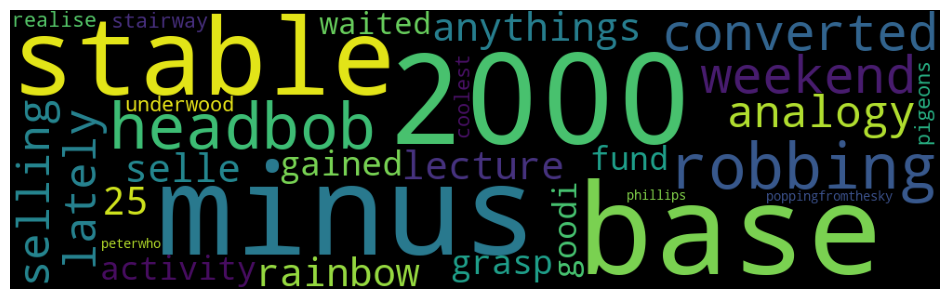

In [9]:
# Les mots associés au "funny"
wc_funny = WordCloud(width=1000, height=300).generate_from_frequencies(
    dict(zip(top_funny_words["word"], np.abs(top_funny_words["log_odds"])))
)

plt.figure(figsize=(12,6))
plt.imshow(wc_funny)
plt.axis("off")
plt.show()


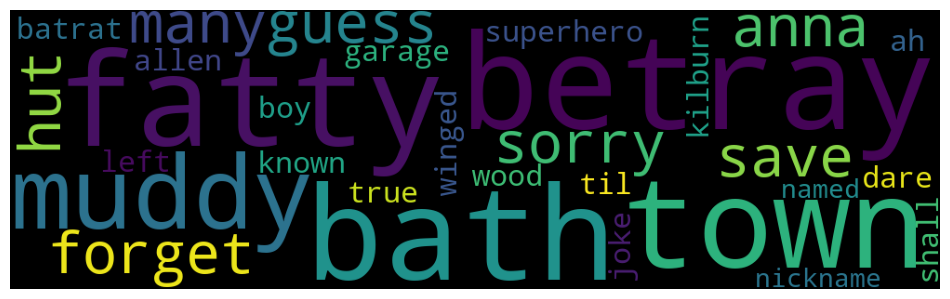

In [10]:
# Les mots "anti-drôles"
wc_notfunny = WordCloud(width=1000, height=300).generate_from_frequencies(
    dict(zip(bottom_funny_words["word"], np.abs(bottom_funny_words["log_odds"])))
)

plt.figure(figsize=(12,6))
plt.imshow(wc_notfunny)
plt.axis("off")
plt.show()


7) Word Embeddings / Similarité sémantique

In [11]:
# Est ce que les captions drôles ont une signature sémantique cohérente ? on va voir cela

model = SentenceTransformer("all-MiniLM-L6-v2")

df_top = df_top.reset_index(drop=True)
df_bottom = df_bottom.reset_index(drop=True)

emb_top = model.encode(df_top["cleaned_caption"], show_progress_bar=True)
emb_bottom = model.encode(df_bottom["cleaned_caption"], show_progress_bar=True)

centroid_top = emb_top.mean(axis=0, keepdims=True)

# Similarité de chaque caption du bottom avec le centroïde des funny
sim_bottom = cosine_similarity(emb_bottom, centroid_top).flatten()
sim_top = cosine_similarity(emb_top, centroid_top).flatten()

print("Similarity top vs centroid:", np.mean(sim_top))
print("Similarity bottom vs centroid:", np.mean(sim_bottom))

ttest_sim, pvalue = ttest_ind(sim_top, sim_bottom)
print(f"T-test similarity: {ttest_sim}, pvalue = {pvalue}")


Batches: 100%|██████████| 219/219 [00:13<00:00, 16.06it/s]


Similarity top vs centroid: 0.36689726
Similarity bottom vs centroid: 0.39056775
T-test similarity: -5.769309750964673, pvalue = 8.265214933998546e-09


In [12]:
def visualize_caption_analysis(df, score_col="mean", text_col="cleaned_caption"):
    """
    Visualize various analyses for funny vs non-funny captions.
    
    Parameters:
    - df : pd.DataFrame with columns [text_col, score_col]
    - score_col : column name for funniness score
    - text_col : column name for cleaned caption
    """
    
    # --- 1) Split top 10% vs bottom 90%
    threshold = df[score_col].quantile(0.9)
    df_top = df[df[score_col] >= threshold].reset_index(drop=True)
    df_bottom = df[df[score_col] < threshold].reset_index(drop=True)
    
    print(f"Top 10% captions: {len(df_top)}, Bottom 90% captions: {len(df_bottom)}")
    
    # --- 2) Bag-of-Words + log-odds
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(df[text_col])
    vocab = np.array(vectorizer.get_feature_names_out())
    freq_top = np.asarray(vectorizer.transform(df_top[text_col]).sum(axis=0)).flatten()
    freq_bottom = np.asarray(vectorizer.transform(df_bottom[text_col]).sum(axis=0)).flatten()
    
    alpha = 0.01
    N_top = freq_top.sum()
    N_bottom = freq_bottom.sum()
    log_odds = (np.log((freq_top + alpha)/(N_top + alpha*len(vocab))) -
                np.log((freq_bottom + alpha)/(N_bottom + alpha*len(vocab))))
    
    # Top 30 et Bottom 30 mots log-odds
    top_words = vocab[np.argsort(log_odds)[-30:]]
    top_vals = log_odds[np.argsort(log_odds)[-30:]]
    bottom_words = vocab[np.argsort(log_odds)[:30]]
    bottom_vals = log_odds[np.argsort(log_odds)[:30]]
    
    # --- 3) WordCloud log-odds
    def plot_wordcloud(words, values, title):
        wc = WordCloud(width=900, height=500).generate_from_frequencies(dict(zip(words, np.abs(values))))
        plt.figure(figsize=(12,6))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.title(title, fontsize=16)
        plt.show()
    
    plot_wordcloud(top_words, top_vals, "Top Funny Words (log-odds)")
    plot_wordcloud(bottom_words, bottom_vals, "Bottom Funny Words (log-odds)")
    
    # --- 4) TF-IDF top words
    tfidf = TfidfVectorizer()
    tfidf_top = tfidf.fit_transform(df_top[text_col])
    features = np.array(tfidf.get_feature_names_out())
    tfidf_means = np.asarray(tfidf_top.mean(axis=0)).flatten()
    top_tfidf_idx = tfidf_means.argsort()[-20:]
    plt.figure(figsize=(12,5))
    sns.barplot(x=tfidf_means[top_tfidf_idx], y=features[top_tfidf_idx])
    plt.title("Top 20 TF-IDF words (top captions)")
    plt.show()
    
    # --- 5) Caption length distributions
    df_top['length'] = df_top[text_col].apply(lambda x: len(x.split()))
    df_bottom['length'] = df_bottom[text_col].apply(lambda x: len(x.split()))
    plt.figure(figsize=(10,5))
    sns.kdeplot(df_top['length'], label="Top 10%", fill=True)
    sns.kdeplot(df_bottom['length'], label="Bottom 90%", fill=True)
    plt.title("Caption length distribution")
    plt.xlabel("Number of words")
    plt.legend()
    plt.show()
    
    # --- 6) Embeddings similarity
    model = SentenceTransformer("all-MiniLM-L6-v2")
    emb_top = model.encode(df_top[text_col], show_progress_bar=False)
    emb_bottom = model.encode(df_bottom[text_col], show_progress_bar=False)
    centroid_top = emb_top.mean(axis=0, keepdims=True)
    sim_top = cosine_similarity(emb_top, centroid_top).flatten()
    sim_bottom = cosine_similarity(emb_bottom, centroid_top).flatten()
    
    plt.figure(figsize=(10,5))
    sns.kdeplot(sim_top, label="Top 10%", fill=True)
    sns.kdeplot(sim_bottom, label="Bottom 90%", fill=True)
    plt.title("Embeddings similarity to Top 10% centroid")
    plt.xlabel("Cosine similarity")
    plt.legend()
    plt.show()
    
    # --- 7) Statistical tests
    t_len = ttest_ind(df_top['length'], df_bottom['length'])
    mw_len = mannwhitneyu(df_top['length'], df_bottom['length'])
    t_sim = ttest_ind(sim_top, sim_bottom)
    
    print("T-test caption length:", t_len)
    print("Mann-Whitney caption length:", mw_len)
    print("T-test similarity embeddings:", t_sim)
    
    return {
        "df_top": df_top,
        "df_bottom": df_bottom,
        "log_odds": log_odds,
        "sim_top": sim_top,
        "sim_bottom": sim_bottom
    }


Top 10% captions: 781, Bottom 90% captions: 6989


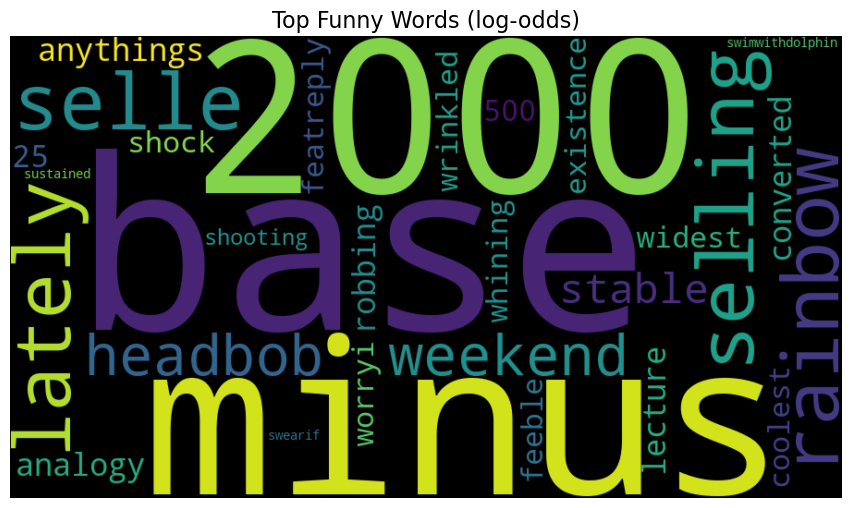

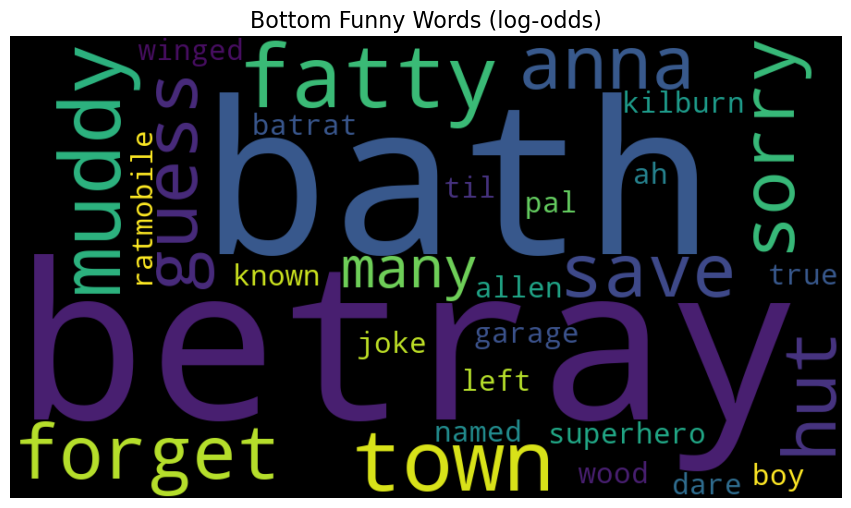

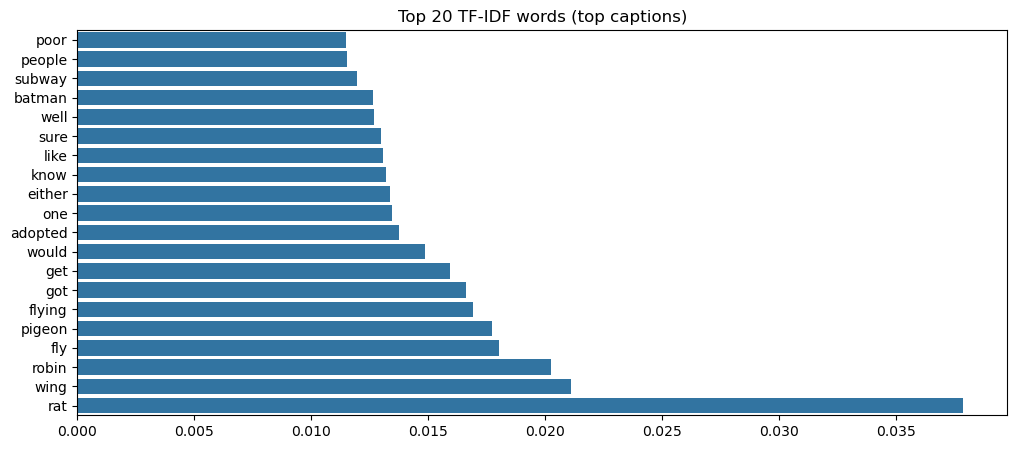

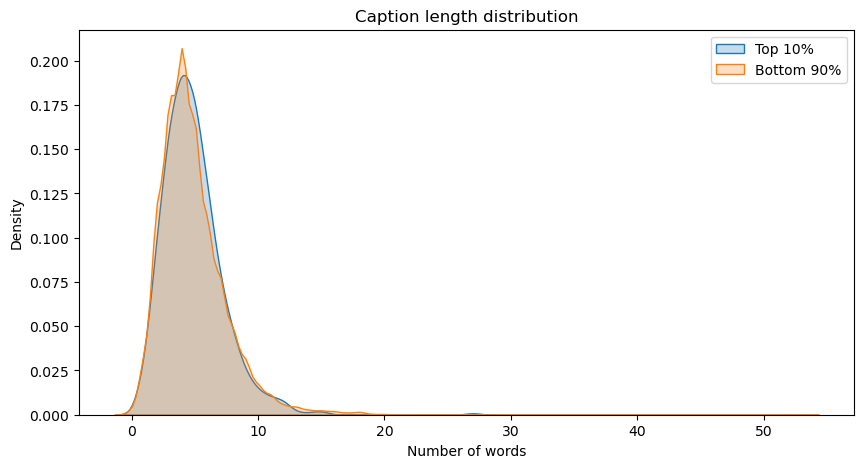

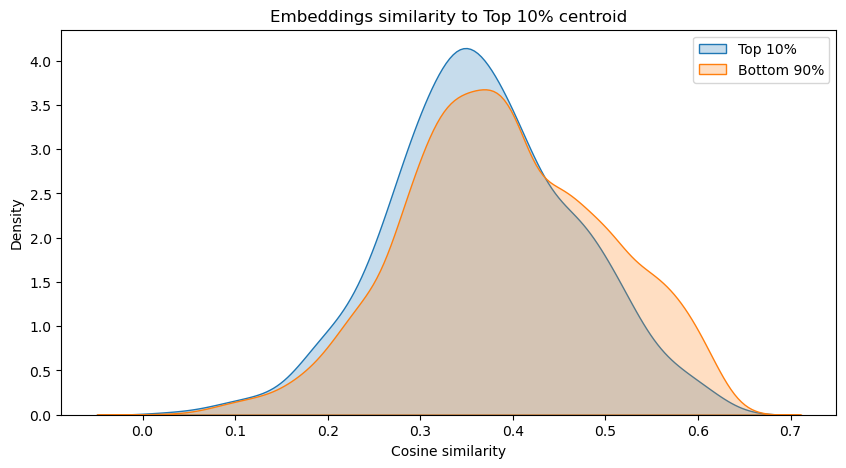

T-test caption length: TtestResult(statistic=np.float64(0.03229796028834252), pvalue=np.float64(0.9742352655961413), df=np.float64(7768.0))
Mann-Whitney caption length: MannwhitneyuResult(statistic=np.float64(2800736.0), pvalue=np.float64(0.2238364223232192))
T-test similarity embeddings: TtestResult(statistic=np.float64(-5.769309750964673), pvalue=np.float64(8.265214933998546e-09), df=np.float64(7768.0))


In [13]:
results = visualize_caption_analysis(df, score_col="mean", text_col="cleaned_caption")

- On va passer de mots isolés → n‑grams (2‑3 mots) pour capturer les jeux de mots et expressions.
N-grams capturent des jeux de mots, tournures drôles et expressions idiomatiques.


- On va calculer log-odds et TF-IDF sur ces n‑grams.
Log-odds / TF-IDF sur n-grams permet de mieux identifier ce qui est spécifique aux captions drôles.


- On fera un WordCloud basé sur ces n‑grams.
Embeddings similarity montre si les captions drôles ont des concepts récurrents.


- On pourra également regrouper les captions par embeddings pour visualiser les concepts humoristiques.
Tu peux adapter ngram_range=(1,3) pour inclure mots seuls + bigrams + trigrams.

In [14]:
def visualize_funny_ngrams(df, score_col="mean", text_col="cleaned_caption", ngram_range=(2,3), top_percent=0.1):
    """
    Visualize funny vs non-funny captions using n-grams and embeddings.
    
    Parameters:
    - df : DataFrame with captions and scores
    - score_col : column name for funniness score
    - text_col : column name for cleaned caption
    - ngram_range : tuple, range of n-grams (min_n, max_n)
    - top_percent : float, top fraction to consider as "funny"
    """
    
    # --- Split top vs bottom
    threshold = df[score_col].quantile(1-top_percent)
    df_top = df[df[score_col] >= threshold].reset_index(drop=True)
    df_bottom = df[df[score_col] < threshold].reset_index(drop=True)
    
    print(f"Top {int(top_percent*100)}% captions: {len(df_top)}, Bottom {100-int(top_percent*100)}%: {len(df_bottom)}")
    
    # --- CountVectorizer for n-grams
    vectorizer = CountVectorizer(ngram_range=ngram_range)
    X_top = vectorizer.fit_transform(df_top[text_col])
    X_bottom = vectorizer.transform(df_bottom[text_col])
    
    vocab = np.array(vectorizer.get_feature_names_out())
    freq_top = np.asarray(X_top.sum(axis=0)).flatten()
    freq_bottom = np.asarray(X_bottom.sum(axis=0)).flatten()
    
    # Log-odds ratio with Dirichlet prior
    alpha = 0.01
    N_top = freq_top.sum()
    N_bottom = freq_bottom.sum()
    log_odds = (np.log((freq_top + alpha)/(N_top + alpha*len(vocab))) -
                np.log((freq_bottom + alpha)/(N_bottom + alpha*len(vocab))))
    
    # Top 30 n-grams
    top_idx = np.argsort(log_odds)[-30:]
    bottom_idx = np.argsort(log_odds)[:30]
    
    # WordCloud function
    def plot_wordcloud(words, values, title):
        wc = WordCloud(width=900, height=500, background_color="white").generate_from_frequencies(dict(zip(words, np.abs(values))))
        plt.figure(figsize=(12,6))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.title(title, fontsize=16)
        plt.show()
    
    plot_wordcloud(vocab[top_idx], log_odds[top_idx], f"Top Funny n-grams ({ngram_range})")
    plot_wordcloud(vocab[bottom_idx], log_odds[bottom_idx], f"Bottom Funny n-grams ({ngram_range})")
    
    # --- TF-IDF n-grams (Top captions)
    tfidf = TfidfVectorizer(ngram_range=ngram_range)
    tfidf_top = tfidf.fit_transform(df_top[text_col])
    features = np.array(tfidf.get_feature_names_out())
    tfidf_means = np.asarray(tfidf_top.mean(axis=0)).flatten()
    
    top_tfidf_idx = tfidf_means.argsort()[-20:]
    plt.figure(figsize=(12,5))
    plt.barh(features[top_tfidf_idx], tfidf_means[top_tfidf_idx])
    plt.title(f"Top 20 TF-IDF n-grams (Top {int(top_percent*100)}%)")
    plt.show()
    
    # --- Embeddings clustering
    model = SentenceTransformer("all-MiniLM-L6-v2")
    emb_top = model.encode(df_top[text_col], show_progress_bar=False)
    emb_bottom = model.encode(df_bottom[text_col], show_progress_bar=False)
    centroid_top = emb_top.mean(axis=0, keepdims=True)
    sim_top = cosine_similarity(emb_top, centroid_top).flatten()
    sim_bottom = cosine_similarity(emb_bottom, centroid_top).flatten()
    
    plt.figure(figsize=(10,5))
    import seaborn as sns
    sns.kdeplot(sim_top, label="Top captions", fill=True)
    sns.kdeplot(sim_bottom, label="Bottom captions", fill=True)
    plt.title("Cosine similarity to Top captions centroid")
    plt.xlabel("Cosine similarity")
    plt.legend()
    plt.show()
    
    print("Mean similarity Top:", np.mean(sim_top))
    print("Mean similarity Bottom:", np.mean(sim_bottom))
    
    return {
        "df_top": df_top,
        "df_bottom": df_bottom,
        "log_odds": log_odds,
        "vocab": vocab,
        "sim_top": sim_top,
        "sim_bottom": sim_bottom
    }


Top 10% captions: 781, Bottom 90%: 6989


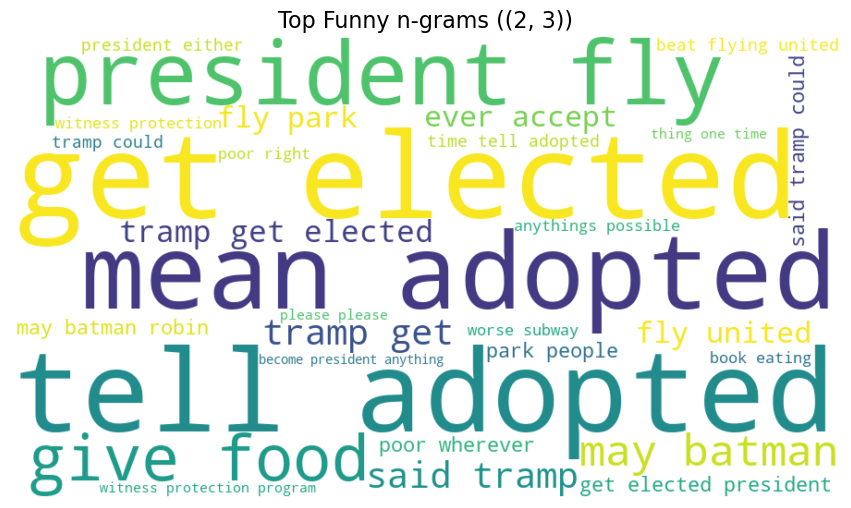

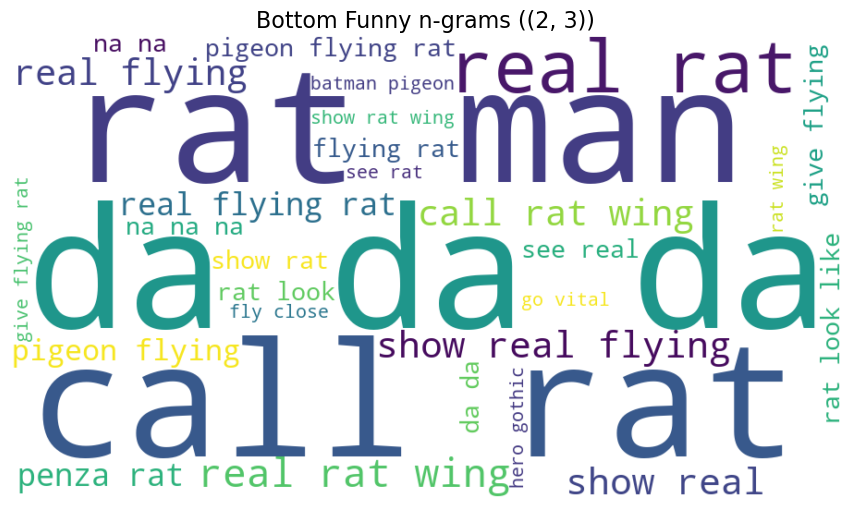

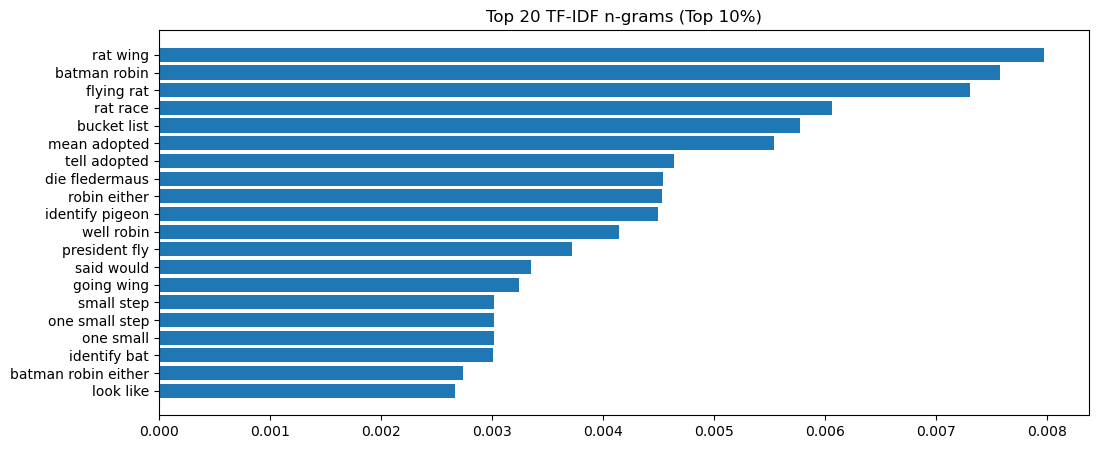

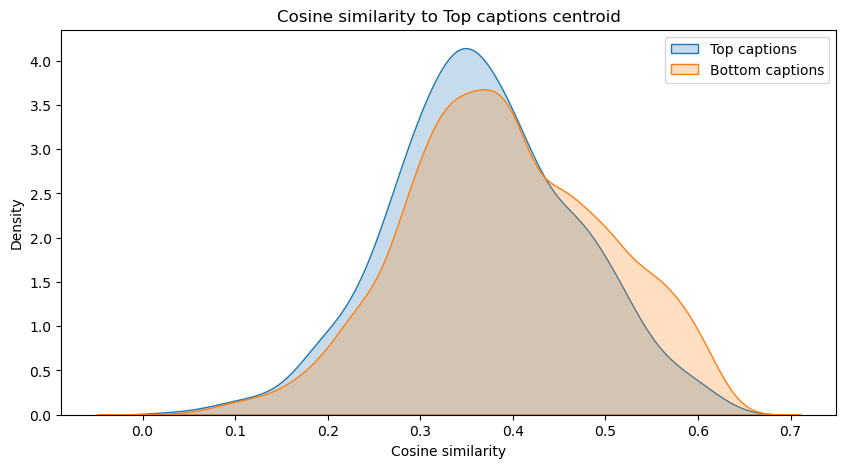

Mean similarity Top: 0.36689726
Mean similarity Bottom: 0.39056775


In [15]:
results = visualize_funny_ngrams(df, score_col="mean", text_col="cleaned_caption", ngram_range=(2,3))

In [38]:
import importlib
from src.utils.gui import plots_gui as pg
importlib.reload(pg)

[autoreload of src.utils.gui.plots_gui failed: Traceback (most recent call last):
  File "c:\Users\cyrie\anaconda3\envs\ada\Lib\site-packages\IPython\extensions\autoreload.py", line 322, in check
    elif self.deduper_reloader.maybe_reload_module(m):
         ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^
  File "c:\Users\cyrie\anaconda3\envs\ada\Lib\site-packages\IPython\extensions\deduperreload\deduperreload.py", line 545, in maybe_reload_module
    new_source_code = f.read()
  File "c:\Users\cyrie\anaconda3\envs\ada\Lib\encodings\cp1252.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
           ~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeDecodeError: 'charmap' codec can't decode byte 0x8f in position 7903: character maps to <undefined>
]


<module 'src.utils.gui.plots_gui' from 'c:\\Users\\cyrie\\OneDrive\\Documents\\EPFL\\2025_MA_1\\ADA\\ada-2025-project-adacore42\\src\\utils\\gui\\plots_gui.py'>

In [39]:
def cluster_funny_captions(df, text_col="cleaned_caption", score_col="mean", top_percent=0.1, n_clusters=5):
    """
    Cluster top funny captions and visualize representative examples.
    
    Parameters:
    - df : DataFrame with captions and scores
    - text_col : column with cleaned captions
    - score_col : funniness score
    - top_percent : top fraction to consider as funny
    - n_clusters : number of clusters
    """
    
    # --- Select top captions
    threshold = df[score_col].quantile(1-top_percent)
    df_top = df[df[score_col] >= threshold].reset_index(drop=True)
    print(f"Selected {len(df_top)} top captions for clustering.")
    
    # --- Encode captions
    model = SentenceTransformer("all-MiniLM-L6-v2")
    embeddings = model.encode(df_top[text_col], show_progress_bar=True)
    
    # --- Clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(embeddings)
    df_top['cluster'] = labels
    
    # --- Analyze each cluster
    cluster_summary = {}
    
    for c in range(n_clusters):
        cluster_idxs = np.where(labels == c)[0]
        cluster_emb = embeddings[cluster_idxs]
        cluster_texts = df_top.loc[cluster_idxs, text_col].tolist()
        
        # Centroid
        centroid = cluster_emb.mean(axis=0, keepdims=True)
        # Similarity to centroid
        sims = cosine_similarity(cluster_emb, centroid).flatten()
        top_idx = sims.argsort()[-5:][::-1]  # top 5 captions closest to centroid
        
        representative_texts = [cluster_texts[i] for i in top_idx]
        
        # WordCloud for cluster
        all_text = " ".join(cluster_texts)
        wc = WordCloud(width=800, height=400, background_color="white").generate(all_text)



        # WordCloud for cluster
        all_text = " ".join(cluster_texts)
        wc = WordCloud(width=800, height=400, background_color="white").generate(all_text)

        """# === 🔽 AJOUT POUR INTEGRATION GUI 🔽 ===
        plot = pg.WordCloudPlotGUI(
            cluster_id=c,
            wordcloud=wc,
            representative_texts=representative_texts
        )
        pg.PlotGUI.add_plots([plot])
        # === 🔼 AJOUT POUR INTEGRATION GUI 🔼 ==="""

        # Display (optional for debugging)
        plt.figure(figsize=(10,5))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Cluster {c} WordCloud (n={len(cluster_texts)})", fontsize=14)
        plt.show()
        
        print(f"Cluster {c} top representative captions:")
        for t in representative_texts:
            print(" -", t)
        print("\n" + "="*50 + "\n")
        
        cluster_summary[c] = {
            "n_captions": len(cluster_texts),
            "representative": representative_texts
        }
    
    return df_top, cluster_summary


Clustering par similarité sémantique → regroupe les captions drôles par thème ou type d’humour.

WordCloud → montre les mots typiques de chaque cluster.

Captions représentatives → les phrases les plus "centrales" dans le cluster, donc très typiques.

Permet de détecter : Jeux de mots sur animaux, Absurdities / incongruité, Références culturelles, Ironie / sarcasme

Selected 781 top captions for clustering.


Batches: 100%|██████████| 25/25 [00:01<00:00, 16.51it/s]


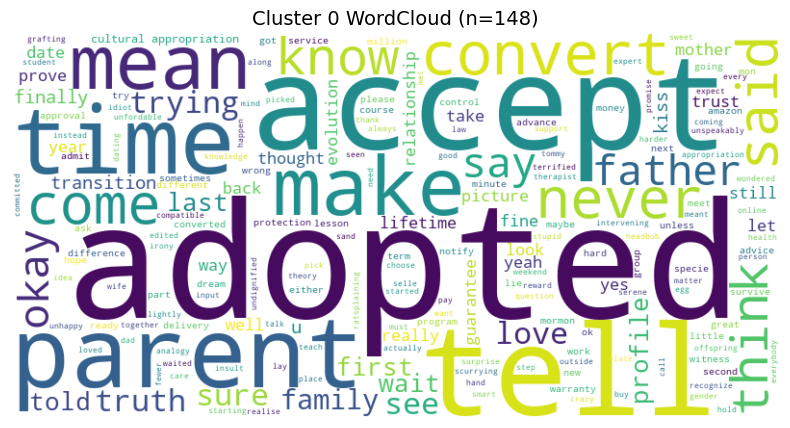

Cluster 0 top representative captions:
 - wait adopted
 - pick tell adopted
 - tell adopted
 - tell adopted
 - great time tell adopted




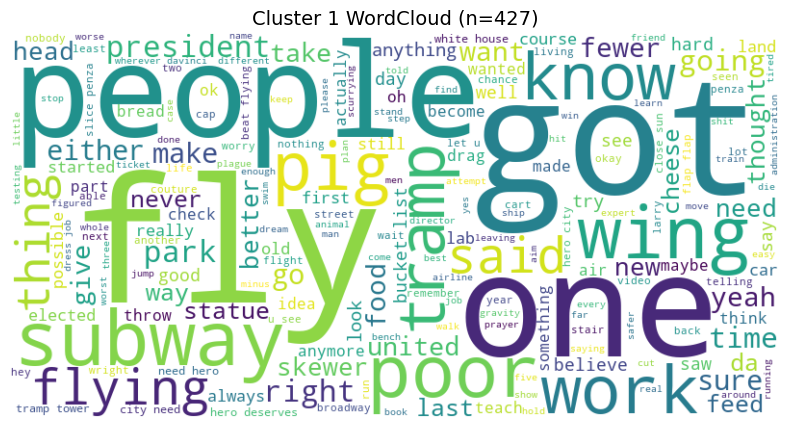

Cluster 1 top representative captions:
 - got flying thing trick get white poor
 - hey pig flew 2016 anythings possible
 - know said would go next never actually thought pig would fly
 - going wing
 - going wing




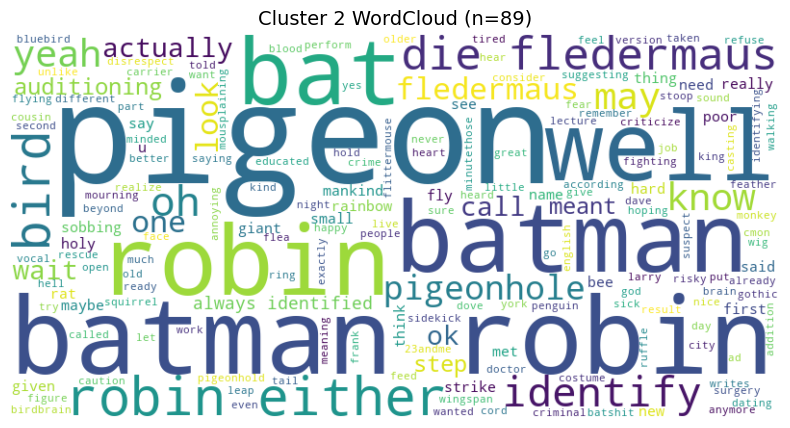

Cluster 2 top representative captions:
 - robin
 - robin
 - robin
 - day rat pigeon night batman robin
 - batman robin




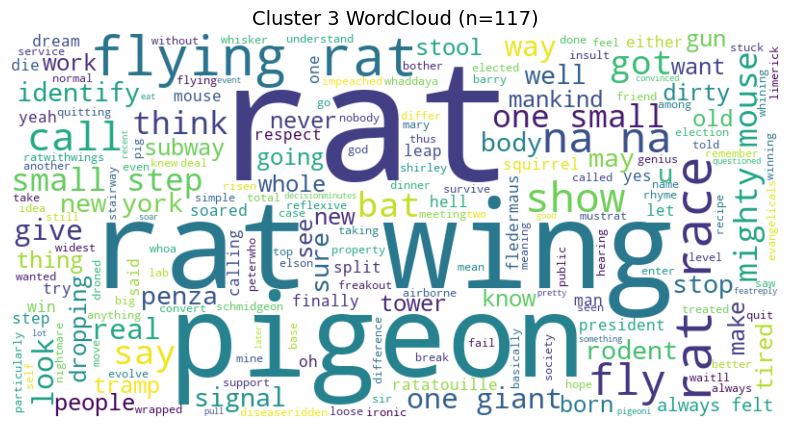

Cluster 3 top representative captions:
 - flying rat
 - flying rat show flying rat
 - show flying rat
 - think flying rat show flying rat
 - call flying rat




In [40]:
df_top_clustered, summary = cluster_funny_captions(df, text_col="cleaned_caption", score_col="mean", top_percent=0.1, n_clusters=4)

Le mot qui revient le plus dans le cartoon (-> re&collection ? vector embedding ? barplot)
COMPARAISON : Est il present dans la description de l’image ? (-> re&collection ? vector embedding de la description de l’image ?)\
-->	Si oui ok, la blague est attendue, passons\
-->	Si non alors il y a une reference exterieure ! analyser à la main la reference culturelle ou alors utiliser dataset exterieur pour trouver la ref ?